## Orbit Demo

Before running this notebook environment values ACSS_CONFIG_FILEPATH and PATH_TO_ACSS_SERVICES_ROOT have to be defined in .env file.

In [1]:
import os
from pathlib import Path


def load_env_file(path_to_env_file: Path):
    with open(path_to_env_file) as f:
        for line in f.readlines():
            line = line.strip('\n')
            split = line.split('=')
            if len(split) == 2:
                key, value = split
                key = key.strip()
                value = value.strip()
                print(f"export {key}={value} ")
                os.environ[key] = value

load_env_file(Path("./.env"))

export ACSS_CONFIG_FILEPATH=/home/boese/projects/acss-services/acss-config.yaml 
export PATH_TO_ACSS_SERVICES_ROOT=/home/boese/projects/acss-services 


Get running Agents and Simulations in ACSS Cluster:

In [9]:
from acss_core.client.utils import get_services
agts, sims = get_services()
print(agts)
print(sims)

{'ConfigToFileService': <acss_core.client.service_client.AgentClient object at 0x7fef3418d790>, 'Observer': <acss_core.client.service_client.AgentClient object at 0x7feed1134af0>, 'OrbitAgent': <acss_core.client.service_client.AgentClient object at 0x7feed1134850>, 'OrbitCorrAgent': <acss_core.client.service_client.AgentClient object at 0x7feed1134430>, 'MachineService': <acss_core.client.service_client.AgentClient object at 0x7feed11343a0>, 'SetTableService': <acss_core.client.service_client.AgentClient object at 0x7feed145e700>, 'SillyAgent': <acss_core.client.service_client.AgentClient object at 0x7feed145e1c0>, 'SillyMeasureAgent': <acss_core.client.service_client.AgentClient object at 0x7feed13fb760>}
{'PetraOrbitSimulation': <acss_core.client.service_client.MachineClient object at 0x7feee6335070>}


In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_orbit(adapter):
    x, y, bpm_names = petra.get_bpms()
    plt.figure(figsize=(20,10)) 
    plt.stem(x, linefmt='blue', markerfmt=".")
    plt.stem(y, linefmt='green', markerfmt=".")   
    plt.grid()
    plt.show()

Use Petra machine adapter to read values:

In [4]:
# get corrector settings, plot
from adapter.petra.PetraMachineAdapter import PetraMachineAdapter
import numpy as np



petra = PetraMachineAdapter.create_for_simulation()

# get corretors

hcor_names = petra.get_hcor_device_names()
hcors = petra.get_hcors(hcor_names)

vcor_names = petra.get_vcor_device_names()
vcors = petra.get_vcors(vcor_names)



[2022-06-20 12:29:46.700] WARNING  Environment value LOGSTASH_SERVER_URL isn't set. Service will not log in central Log DB only to stdout.
[2022-06-20 12:29:46.703] INFO  Logging is set to stdout.
[2022-06-20 12:29:46.719] WARNING  Environment value LOGSTASH_SERVER_URL isn't set. Service will not log in central Log DB only to stdout.
[2022-06-20 12:29:46.721] INFO  Logging is set to stdout.
[2022-06-20 12:29:46.726] WARNING  Environment value LOGSTASH_SERVER_URL isn't set. Service will not log in central Log DB only to stdout.
[2022-06-20 12:29:46.728] INFO  Logging is set to stdout.
[2022-06-20 12:29:46.732] WARNING  Environment value LOGSTASH_SERVER_URL isn't set. Service will not log in central Log DB only to stdout.
[2022-06-20 12:29:46.733] INFO  Logging is set to stdout.
[2022-06-20 12:29:46.736] WARNING  Environment value LOGSTASH_SERVER_URL isn't set. Service will not log in central Log DB only to stdout.
[2022-06-20 12:29:46.738] INFO  Logging is set to stdout.
[2022-06-20 12:

Set correctors randomly:

[2022-06-20 12:29:56.755] DEBUG  service name = PetraOrbitSimulation


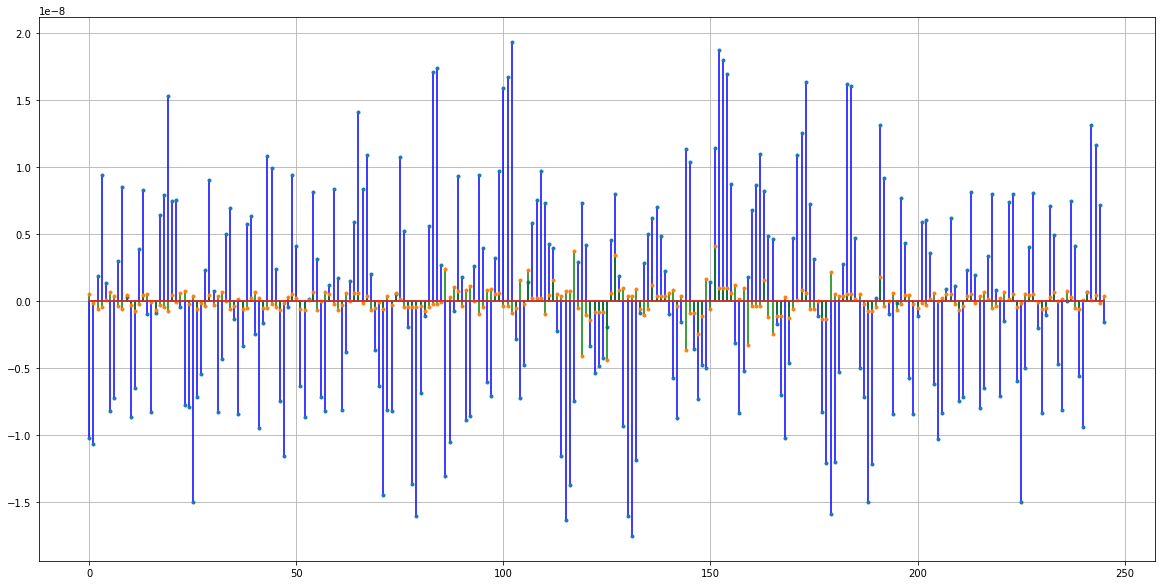

In [5]:
from acss_core.adapter.MsgBusWriter import MessageBusWriter

writer = MessageBusWriter('console', is_sync=True, simulations=['PetraOrbitSimulation'])
writer("/PETRA/Cms.PsGroup", "CORS", "Strength.Random", input=(0, 10))
writer.commit()
plot_orbit(petra)

Set correctors with reandom values using SetTableService:

[2022-06-20 12:30:52.988] DEBUG  service name = SetTableService
[2022-06-20 12:30:57.253] DEBUG  service name = PetraOrbitSimulation


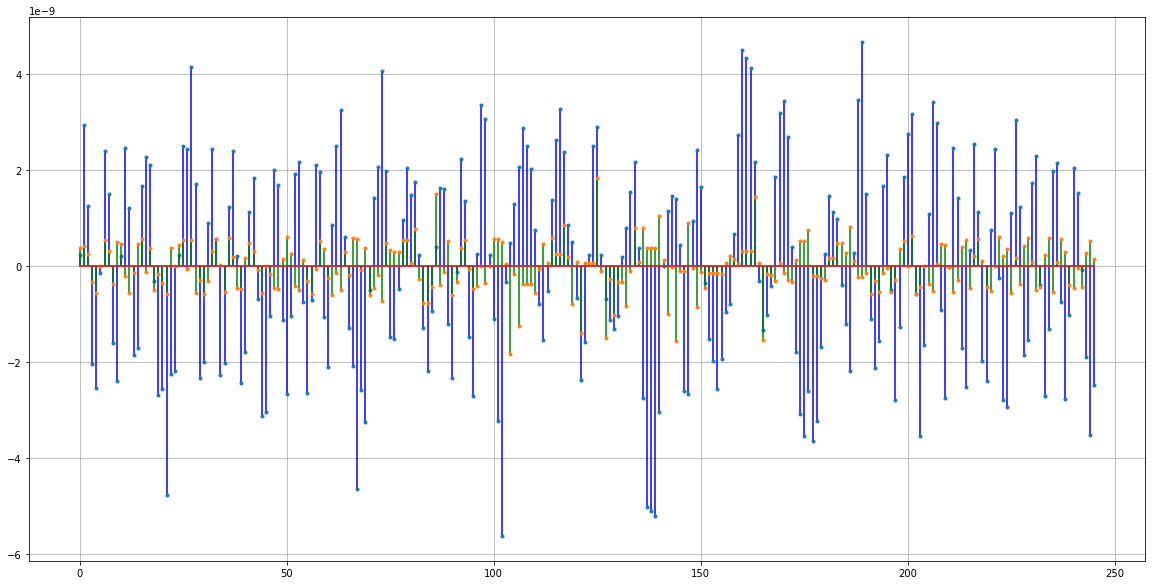

In [7]:
# set correctors random

agts['SetTableService'].run(params={'data':[{'names': hcor_names, 'values': [np.random.rand()*1e-4 for _ in hcor_names], 'type': 'hcor'}, 
                                        {'names': vcor_names, 'values': [np.random.rand()*1e-4 for _ in vcor_names], 'type': 'vcor'}]}, 
                            wait_for_sims=['PetraOrbitSimulation'])
plot_orbit(petra)

Run oribit corrector agent to correct orbit:

Before:


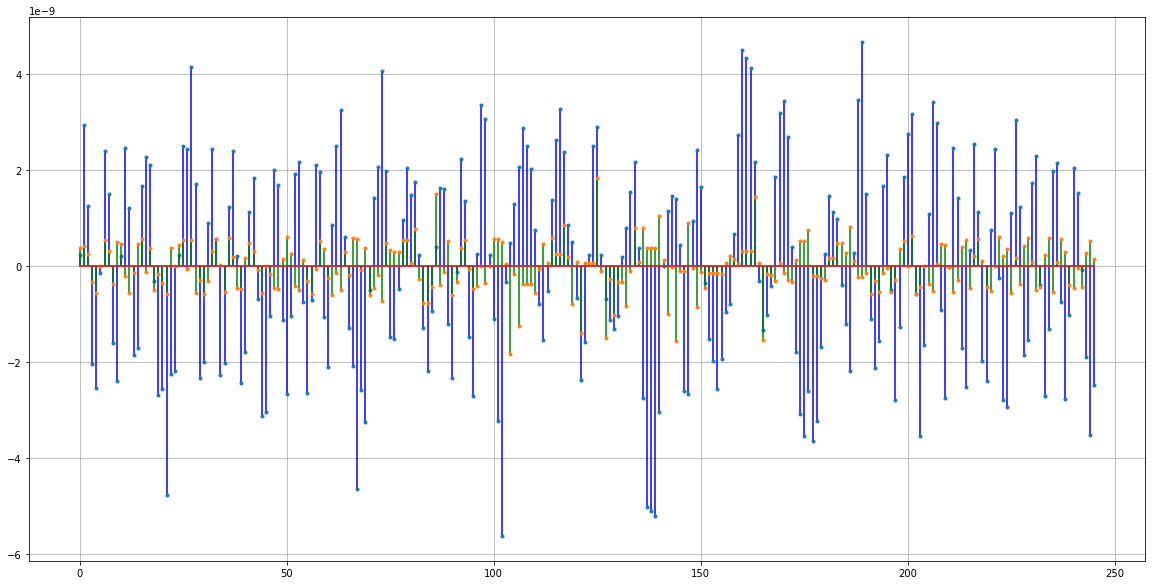

[2022-06-20 12:31:04.154] DEBUG  service name = OrbitCorrAgent
[2022-06-20 12:31:10.693] DEBUG  service name = OrbitCorrAgent
[2022-06-20 12:31:15.170] DEBUG  service name = PetraOrbitSimulation
None
After:


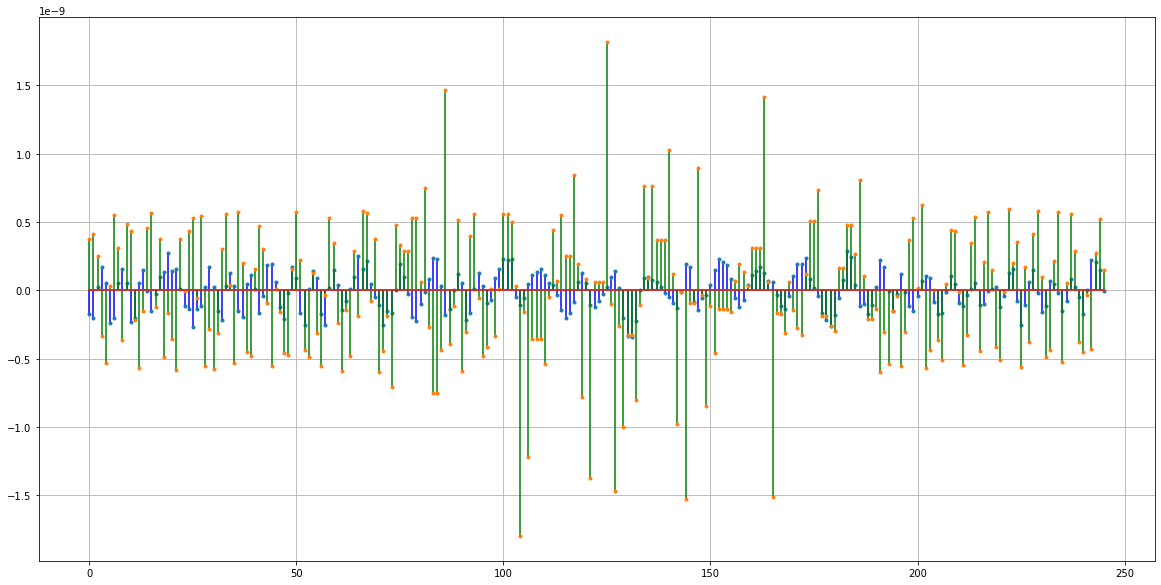

In [8]:
# get orbit, , plot
print("Before:")
plot_orbit(petra)

agts['OrbitCorrAgent'].reconfig({'x_factor': 1000000.0, 'y_factor': 0.0, 'n_sv_x':200, 'n_sv_y':200}, sync=True)
# correct orbit
for _ in range(1):
    print(agts['OrbitCorrAgent'].run(wait_for_sims=['PetraOrbitSimulation']))

    res = agts['OrbitCorrAgent'].get_result()
# get orbot, plot
print("After:")
plot_orbit(petra)

agt_hcor = { name: val for name, val in zip(res.result['hcor'],res.result['hcor_val'])}
agt_vcor = { name: val for name, val in zip(res.result['vcor'],res.result['vcor_val'])}